Experiment Summary:
1 subject(s)	 3 runs	 85 trials/run	 255 total trials
Von Mise Parameters: amplitude -1.5567, Kai 16.0147.
Half Amplitude: 5.9327
Half Width: 5.7692
Von Mise Parameters: amplitude -1.8420, Kai -3.7131.
Half Amplitude: 1.5361
Half Width: 87.2910


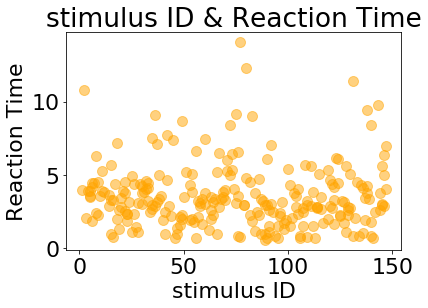

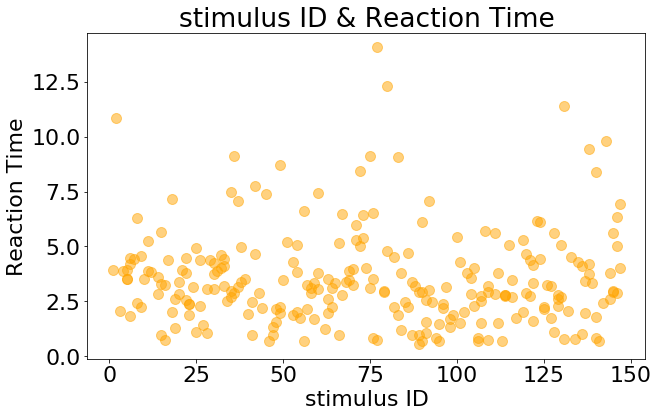

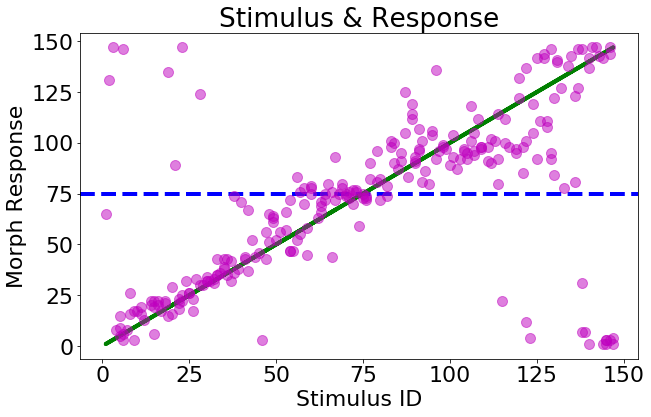

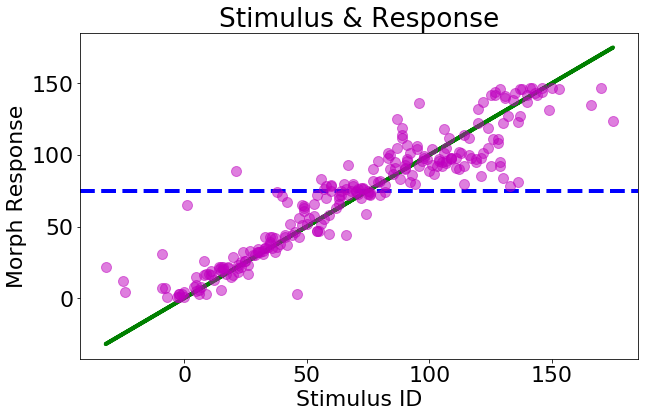

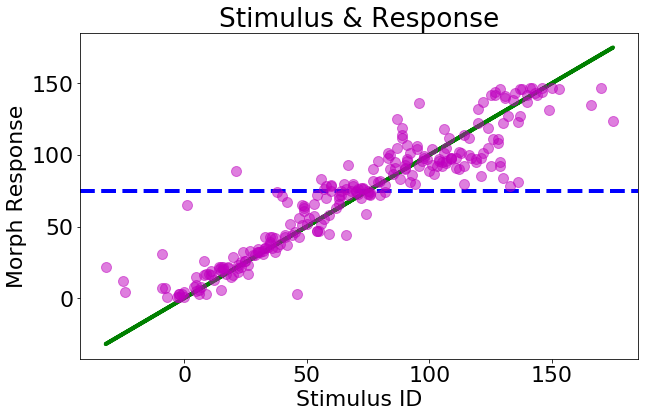

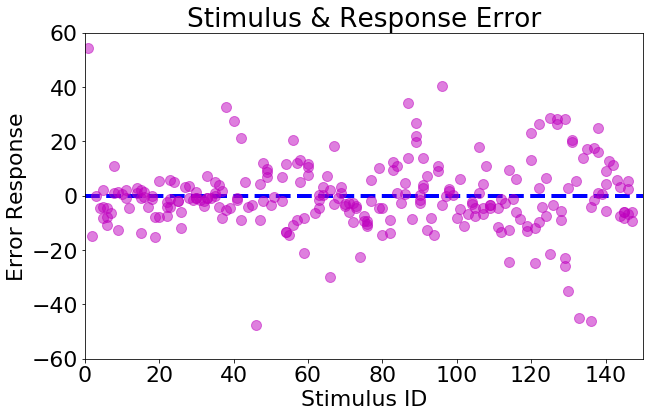

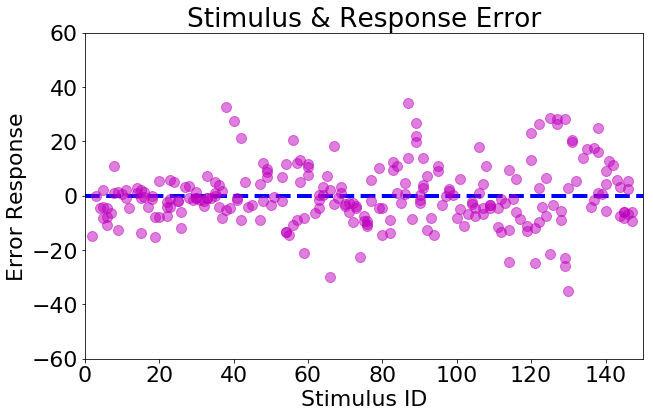

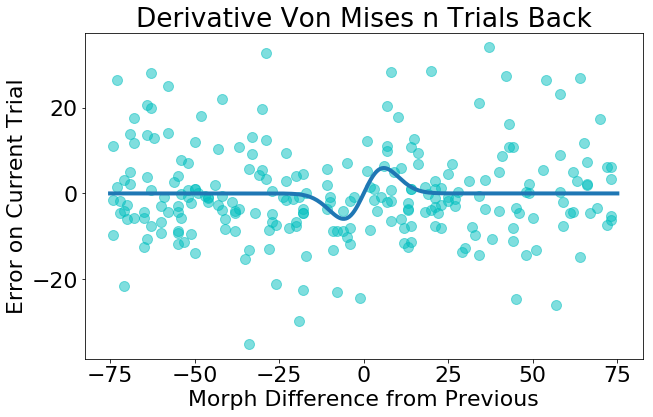

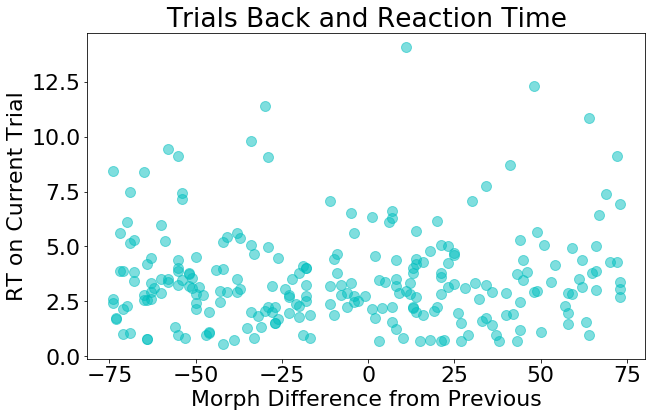

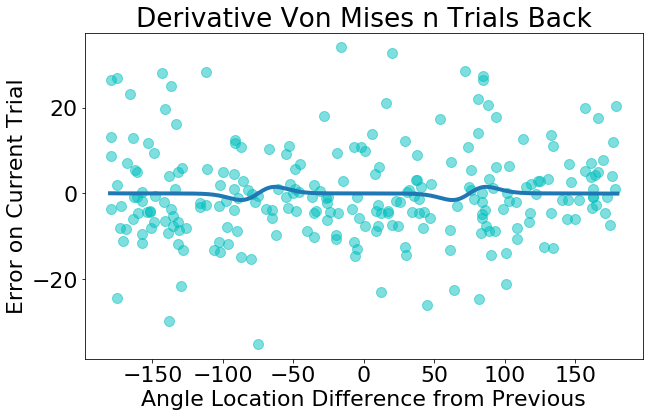

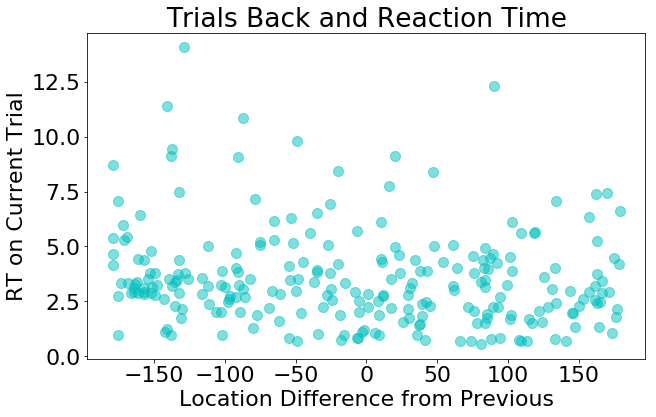

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util import get_multiFrames

from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos

class Subject:
    def __init__(self, dataFrame, RT_threshold=20, std_factors=3, polyfit_order=8, stimulus_maxID=147):
        self.data = dataFrame
        self.std_factors = std_factors
        self.RT_threshold = RT_threshold
        self.polyfit_order = polyfit_order
        self.stimulus_maxID = stimulus_maxID
        
        self.current_stimuliDiff = []

    def toLinear(self):
        for i in range(len(self.data['stimulusID'])):
            if abs(self.data.loc[i,'morphID'] - self.data.loc[i, 'stimulusID']) >= 80: ## threshold need to change accroding to different patterns
                if self.data.loc[i, 'stimulusID'] < self.stimulus_maxID / 2.0:
                    self.data.loc[i, 'stimulusID'] += self.stimulus_maxID
                else:
                    self.data.loc[i, 'stimulusID'] -= self.stimulus_maxID

    def fromLinear(self):
        for i in range(len(self.data['stimulusID'])):
            if self.data.loc[i, 'stimulusID'] <= 0:
                self.data.loc[i, 'stimulusID'] += self.stimulus_maxID
            elif self.data.loc[i, 'stimulusID'] > self.stimulus_maxID: 
                self.data.loc[i, 'stimulusID'] -= self.stimulus_maxID
            else:
                continue

    def polyCorrection(self):
        coefs = np.polyfit(self.data['stimulusID'], self.data['morphID'], self.polyfit_order) # polynomial coefs
        self.data['responseError'] = [y - polyFunc(x, coefs) for x,y in zip(self.data['stimulusID'],self.data['morphID'])]
        self.data['responseError'] = recenter(self.data['responseError'])
    
    def getnBack_diff(self, nBack):
        differencePrevious_stimulusID = []
        differencePrevious_stimulusLoc = []
        filtered_y = []
        filter_RT = []
        for i in range(len(self.data['stimulusID'])):
            if self.data.loc[i, 'trialNumber'] <= nBack:
                continue
            else:
                differencePrevious_stimulusID.append(self.data.loc[i-nBack, 'stimulusID'] - self.data.loc[i, 'stimulusID'])
                differencePrevious_stimulusLoc.append(self.data.loc[i-nBack, 'stimLocationDeg'] - self.data.loc[i, 'stimLocationDeg'])
                filtered_y.append(self.data.loc[i, 'responseError'])
                filter_RT.append(self.data.loc[i, 'RT'])
        
        differencePrevious_stimulusID = recenter(differencePrevious_stimulusID)
        differencePrevious_stimulusLoc = recenter(differencePrevious_stimulusLoc, threshold=180)
        self.current_stimuliDiff = differencePrevious_stimulusID

        return differencePrevious_stimulusID, differencePrevious_stimulusLoc, filtered_y, filter_RT

    def outlier_removal_RT(self):
        self.data = self.data[self.data['RT'] <= self.RT_threshold]
        self.data = self.data.reset_index()

    def outlier_removal_error(self):
        error_mean = np.mean(self.data['responseError'])
        error_std = np.std(self.data['responseError'])
        self.data = self.data[self.data['responseError'] <= error_mean + self.std_factors * error_std]
        self.data = self.data[self.data['responseError'] >= error_mean - self.std_factors * error_std]
        self.data = self.data.reset_index()
    
    def save_RTfigure(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('stimulus ID & Reaction Time')
        plt.xlabel('stimulus ID')
        plt.ylabel('Reaction Time')
        plt.plot(self.data['stimulusID'], self.data['RT'], 'o', color ='orange', alpha=0.5, markersize=10)
        plt.savefig(filename, dpi=150)
        

    def save_SRfigure(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('Stimulus & Response')
        plt.xlabel('Stimulus ID')
        plt.ylabel('Morph Response')
        plt.axhline(y=75, linewidth=4, linestyle = "--", color='b', label = 'y = 75' )
        plt.plot(self.data['stimulusID'], self.data['stimulusID'], linewidth=4, linestyle = "-", color='g', label = 'x = y')
        plt.plot(self.data['stimulusID'], self.data['morphID'], 'mo', alpha=0.5, markersize=10)
        plt.savefig(filename, dpi=150)
    
    def save_Errorfigure(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('Stimulus & Response Error')
        plt.xlabel('Stimulus ID')
        plt.ylabel('Error Response')
        plt.xlim(0, 150)
        plt.ylim(-60, 60)
        plt.axhline(y=0, linewidth=4, linestyle = "--", color='b', label = 'y = 0' )
        plt.plot(self.data['stimulusID'], self.data['responseError'], 'mo', alpha=0.5, markersize=10)
        plt.savefig(filename, dpi=150)
    
    def Extract_currentCSV(self, nBack, fileName):
        ## FileName: SubjectName_nBack_outlierRemoveornot
        ## Delete rows
        output_data = self.data.copy(deep=True)

        for i in range(nBack):
            output_data = output_data[output_data['trialNumber'] != i + 1]
        # output_data = output_data.reset_index()

        output_data['Stim_diff'] = self.current_stimuliDiff
        del output_data['level_0']
        del output_data['index']
        del output_data['blockType']
        output_data.to_csv(fileName, index=False, header=True)



def vonmise_derivative(xdata, a = 25, kai = 4):
    xdata = xdata / 75 * np.pi
    return - a / (i0(kai) * 2 * np.pi) * exp(kai * cos(xdata)) * kai * sin(xdata) # Derivative of vonmise formula

def polyFunc(x, coeffs):

	# Compute the value of a polynomial function given its coefficients.

    # Args:
    #     x (float)
    #     coefs (List[float]): coefficients of a polynomial function. Order from high to low.
	
	# Returns:
	# 	y (float): the polynomial function value.

    y = 0
    order = len(coeffs)
    for i in range(order):
        y += coeffs[i] * (x ** (order - 1 - i))
    return y

def recenter(x, threshold=74):
    for i in range(len(x)):
        if x[i] > threshold - 1:
            x[i] = x[i] - 2 * threshold
        elif x[i] < -threshold:
            x[i] = x[i] + 2 * threshold
    return x

if __name__ == "__main__":
    ### Read data ###
    path = './' ## the folder path containing all experiment csv files
    data = get_multiFrames(path)

    nBack = 1
    outputCSV_name = 'test.csv'

    ### Initialize a subject ###
    subject = Subject(data)

    subject.save_RTfigure('ReactionTime.pdf')
    subject.outlier_removal_RT()
    subject.save_RTfigure('ReactionTime_OutlierRemoved.pdf')
    subject.save_SRfigure('RawData.pdf')

    ### Polynomial Correction ###
    subject.toLinear()
    subject.save_SRfigure('CorrectedData.pdf')
    subject.polyCorrection()
    subject.save_SRfigure('PolyFit.pdf') #We need to add the poly line as well as the line y=x
    subject.fromLinear()
    subject.save_Errorfigure('ErrorResponse.pdf')
    subject.outlier_removal_error()
    subject.save_Errorfigure('ErrorResponse_OutlierRemoved.pdf')

    ## Compute the stimulus difference ##
    stimuli_diff, loc_diff, filtered_responseError, filtered_RT = subject.getnBack_diff(nBack)
    subject.Extract_currentCSV(nBack, outputCSV_name)

    ## Von Mise fitting: Shape Similarity##
    init_vals = [25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, stimuli_diff, filtered_responseError, p0=init_vals)
    print('Von Mise Parameters: amplitude {0:.4f}, Kai {1:.4f}.'.format(best_vals[0],best_vals[1]))

    plt.figure()
    plt.title("Derivative Von Mises n Trials Back")
    plt.xlabel('Morph Difference from Previous')
    plt.ylabel('Error on Current Trial')
    plt.plot(stimuli_diff, filtered_responseError, 'co', alpha=0.5, markersize=10)
    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    plt.plot(x, y, '-', linewidth = 4)
    plt.savefig('ShapeDiff_DerivativeVonMises.pdf', dpi=150)

    print('Half Amplitude: {0:.4f}'.format(np.max(y)))
    print('Half Width: {0:.4f}'.format(x[np.argmax(y)]))
    
    ## Trials back and Reaction Time for Shape##
    plt.figure()
    plt.title("Trials Back and Reaction Time")
    plt.xlabel('Morph Difference from Previous')
    plt.ylabel('RT on Current Trial')
    plt.plot(stimuli_diff, filtered_RT, 'co', alpha=0.5, markersize=10)
    x = np.linspace(-75, 75, 300)
    plt.savefig('TrialsBack_RT_Shape.pdf', dpi=150)
    
     ## Von Mise fitting: Location Similarity##
    init_vals = [25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, loc_diff, filtered_responseError, p0=init_vals)
    print('Von Mise Parameters: amplitude {0:.4f}, Kai {1:.4f}.'.format(best_vals[0],best_vals[1]))

    plt.figure()
    plt.title("Derivative Von Mises n Trials Back")
    plt.xlabel('Angle Location Difference from Previous')
    plt.ylabel('Error on Current Trial')
    plt.plot(loc_diff, filtered_responseError, 'co', alpha=0.5, markersize=10)
    x = np.linspace(-180, 180, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    plt.plot(x, y, '-', linewidth = 4)
    plt.savefig('LocationDiff_DerivativeVonMises.pdf', dpi=150)

    print('Half Amplitude: {0:.4f}'.format(np.max(y)))
    print('Half Width: {0:.4f}'.format(x[np.argmax(y)]))
    
    ## Trials back and Reaction Time for Location##
    plt.figure()
    plt.title("Trials Back and Reaction Time")
    plt.xlabel('Location Difference from Previous')
    plt.ylabel('RT on Current Trial')
    plt.plot(loc_diff, filtered_RT, 'co', alpha=0.5, markersize=10)
    x = np.linspace(-180, 180, 300)
    plt.savefig('TrialsBack_RT_Location.pdf', dpi=150)  